This is my first work on kaggle. Any feedback to improve my work will be appreciated. Thanks.


# 1. Collecting the data:


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

First we read the input files using pandas library into the corresponding dataframes, where **train** will be used to train the model(s) and **test** will be used to predict the missing response variable. 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 2. Pre-processing the data:

Let us check the first few columns of each dataframe:

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We see that the response variable **Survived** is missing in the **test** dataframe because the goal is to predict it. Next we save the **Survived** column in the traning dataset into a separate list to be used later to train the model(s) we will be using. But first, we make sure that the target feature **Survived** doesn't contain any missing data as follows:

In [5]:
train['Survived'].isnull().sum()

0

It seems it doesn't have any missing data. So, we go ahead and save it into a separete list, and drop it from the training dataset. We do this in order to combine the training and testing datasets to be pre-processed together, and the testing dataset doesn't have the traget feature column. 

In [6]:
survived = train['Survived']
train.drop('Survived', axis = 1, inplace = True)

Also, the column **PassengerId** in the testing dataset is required for the final reporting of the results, and thus, we will save it into a separate list, because it will be dropped in the next step for its unlikely relevance to the target feature **Survived**. First, as we did with the **Survived** feature, we check if it has any missing data, and then save it into a separete list. Note that we won't drop this column here, because there is a corresponding column in the training dataset, and it will be dropped at once from both datasets after we combine them for pre-processing as we will see in the next step.

In [7]:
test['PassengerId'].isnull().sum()

0

In [8]:
PssId = test['PassengerId']

At this stage, we will combine the training and testing datasets to pre-process the data in both files at once. So, we concatenate the two dataframes, and use multi-level indexing such that the rows that correspond to the traning dataset have a level 0 index of **train**. Similarily, the rows that correspong to the testing dataset have a level 0 index of **test**. This will make it easier later on to retrieve the data that belong to each dataset after completing the pre-processing step.

In [9]:
train_test = pd.concat([train,test], keys = ['train', 'test'], names = ['dataset', 'index'])
train_test.head()

PassengerId  Pclass  \
dataset index                        
train   0                1       3   
        1                2       1   
        2                3       3   
        3                4       1   
        4                5       3   

                                                            Name     Sex  \
dataset index                                                              
train   0                                Braund, Mr. Owen Harris    male   
        1      Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
        2                                 Heikkinen, Miss. Laina  female   
        3           Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
        4                               Allen, Mr. William Henry    male   

                Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
dataset index                                                                
train   0      22.0      1      0         A/5 21171   7.2500   NaN        S  
        1      38.0      1      0          PC 17599  71.2833   C85        C  
        2      26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
        3      35.0      1      0            113803  53.1000  C123        S  
        4      35.0      0      0            373450   8.0500   NaN        S

Now that we have combined the datasets, we can clean the data, and keep the relevent features. Let us first check the details of the combined dataframes.

In [10]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 0) to (test, 417)
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 123.4+ KB


We see that we have 11 features, all of which seems to have the correct datatypes. So, we don't need to cast any datatypes. We also note that we have 1309 observations. Comparing the number of non-null values in each feature with this total number of observations reveals that some features have some missing data. These features are: **Age**, **Fare**, **Cabin**, and **Embarked**. We will address these missing data shortly. 

Intuitively, the **Name** column has no effect on the survival rate of the person. So, it is probably safe to drop it. The **Ticket** feature also doesn't seem to have any information that could distinguish the survival probability of different ticket holders. So, it can be dropped as well. **PassengerId** is just a sequential number in the datasets, and it's unlikely to have any effect in the data. So, it will also be droped.

In [11]:
train_test.drop(['PassengerId','Name', 'Ticket'], axis = 1, inplace = True)
train_test.head()

Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
dataset index                                                            
train   0           3    male  22.0      1      0   7.2500   NaN        S
        1           1  female  38.0      1      0  71.2833   C85        C
        2           3  female  26.0      0      0   7.9250   NaN        S
        3           1  female  35.0      1      0  53.1000  C123        S
        4           3    male  35.0      0      0   8.0500   NaN        S

Let us check how many missing data each feature has:

In [12]:
train_test.isnull().sum()

Pclass         0
Sex            0
Age          263
SibSp          0
Parch          0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

We see that **Cabin** has many (> 75%) missing data. So, it will be dropped. **Age** and **Fare** are numeric features, and thus the missing data can be replaced with some average of the avilable data for the respective features. Lastly, **Embarked** is a categorical feature, and thus the missing data will be replaced with the most frequent level. 

In [13]:
train_test.drop(['Cabin'], axis = 1, inplace = True)

In [14]:
age_summary = train.groupby(by = ['Sex','Pclass'])['Age'].describe()
age_summary

count       mean        std   min     25%   50%    75%   max
Sex    Pclass                                                              
female 1        85.0  34.611765  13.612052  2.00  23.000  35.0  44.00  63.0
       2        74.0  28.722973  12.872702  2.00  22.250  28.0  36.00  57.0
       3       102.0  21.750000  12.729964  0.75  14.125  21.5  29.75  63.0
male   1       101.0  41.281386  15.139570  0.92  30.000  40.0  51.00  80.0
       2        99.0  30.740707  14.793894  0.67  23.000  30.0  36.75  70.0
       3       253.0  26.507589  12.159514  0.42  20.000  25.0  33.00  74.0

From the above summary, it clear that the average ages of different genders and of different classes are different. So, we will go ahead and replace the missing data in the Age column based on the gender and class.

In [15]:
where_age_is_null = train_test['Age'].isnull()
age_missing_data = train_test[where_age_is_null]
# age_df = train_test[~ where_age_is_null]

#age_missing_data = pd.get_dummies(age_missing_data, columns = ['Sex', 'Embarked'], drop_first = True)
# age_df = pd.get_dummies(age_df, columns = ['Sex', 'Embarked'], drop_first = True)

print(age_missing_data.head())
print("================================================================")
# print(age_df.head())

# from sklearn.linear_model import LinearRegression
# linear_regressor = LinearRegression()

# linear_regressor.fit(age_df.drop('Age', axis = 1), age_df['Age'])
# age_missing_data['Age'] = linear_regressor.predict(age_missing_data.drop('Age', axis = 1))

# print(age_missing_data.head())
# print("================================================================")
# print(age_df.head())

               Pclass     Sex  Age  SibSp  Parch     Fare Embarked
dataset index                                                     
train   5           3    male  NaN      0      0   8.4583        Q
        17          2    male  NaN      0      0  13.0000        S
        19          3  female  NaN      0      0   7.2250        C
        26          3    male  NaN      0      0   7.2250        C
        28          3  female  NaN      0      0   7.8792        Q


In [16]:
fill_age = []
for index, row in age_missing_data.iterrows():
    fill_age.append(round(age_summary.xs([row['Sex'], row['Pclass']])['mean'],0))

train_test.loc[where_age_is_null, 'Age'] = fill_age#This contains the mean value of age based on gender and class for each missing data in age
train_test[where_age_is_null].head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
dataset index                                                      
train   5           3    male  27.0      0      0   8.4583        Q
        17          2    male  31.0      0      0  13.0000        S
        19          3  female  22.0      0      0   7.2250        C
        26          3    male  27.0      0      0   7.2250        C
        28          3  female  22.0      0      0   7.8792        Q

In [17]:
train_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    2
dtype: int64

In [18]:
train_test['Embarked'].describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

From the above summary of the **Embarked** feature, the most frequent level is 'S' (it occured 914 times out of the available 1307 information for the Embarked feature, with a fraction of 914/1307 = 0.70). The count of all  levels can be found as following:

In [19]:
train_test['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

The other two levels for the **Embarked** feature are 'C' and 'Q', with 270 and 123 occurences, respectively. Based on the above information, we can fill the missing data in the **Embarked** feature by the most frequent level, namely, 'S'. 

In [20]:
train_test['Embarked'] = train_test['Embarked'].fillna('S')

Now, let's address the remaining feature that has missing data, namely, the **Fare** feature. 

In [21]:
train_test['Fare'] = train_test['Fare'].fillna(train_test['Fare'].mean())

In [22]:
train_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Now our data looks clean in the sense that there is no more missing data. Next, we wll move forward to explore our data using exploratory data analysis (EDA).

In [23]:
# where_age_is_null = train_test['Age'].isnull()
# age_missing_data = train_test[where_age_is_null]
# age_df = train_test[~ where_age_is_null]

# age_missing_data = pd.get_dummies(age_missing_data, columns = ['Sex', 'Embarked'], drop_first = True)
# age_df = pd.get_dummies(age_df, columns = ['Sex', 'Embarked'], drop_first = True)

# print(age_missing_data.head())
# print("================================================================")
# print(age_df.head())



In [24]:
# from sklearn.linear_model import LinearRegression
# linear_regressor = LinearRegression()

# linear_regressor.fit(age_df.drop('Age', axis = 1), age_df['Age'])
# age_missing_data['Age'] = linear_regressor.predict(age_missing_data.drop('Age', axis = 1))

# age_missing_data['Age'] = age_missing_data['Age'].apply(lambda x: round(x, 2))

# train_test.loc[where_age_is_null, 'Age'] = age_missing_data['Age']

# print(age_missing_data.head())
# print("================================================================")
# print(age_df.head())

# 3. EDA Analysis:

Now, let's us do some exploratory data analysis. Before we  do that, let's split the data again to training and testing datasets.

In [25]:
train = train_test.loc['train']
test = train_test.loc['test']

To do analysis related to the survival status, let's us append the Survived column again to the traning dataset.

In [26]:
train['Survived'] = survived
train.head()

C:\Anacoda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
index,,,,,,,,
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [27]:
train.shape

(891, 8)

First, let's examine the average survival rate as a percentage.

In [28]:
train['Survived'].mean()

0.3838383838383838

Our training data shows that around 38.4% of the passengers survived the Titanic disaster, or that around 61.6% died in the accident. In reality, 68% were lost in the disaster. So, we can say that the dataset here is representative. The discrepency is due to the fact the training set is a sample of the people who were on the boat. This 61.6% translates into 549 people who would have died in the distater, had the sample in the traning dataset been on the ship (see the following plot).

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

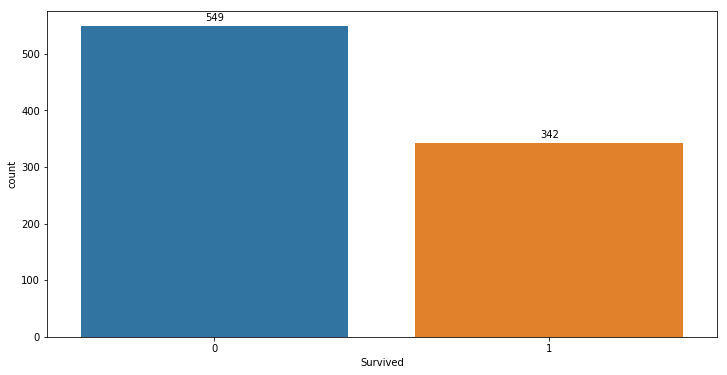

In [30]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Survived', data = train)
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

# 3.1 Categorical Features:
## 3.1.1 Sex:

Let's start with the **Sex** feature. From the following plot, we can see  that the gender of the passenger had a significant effect on the survival rate, where about $(468/549) \simeq  85\%$ of the passengers who were lost were men, while only $(109/342) \simeq 32\%$ who survived were men.

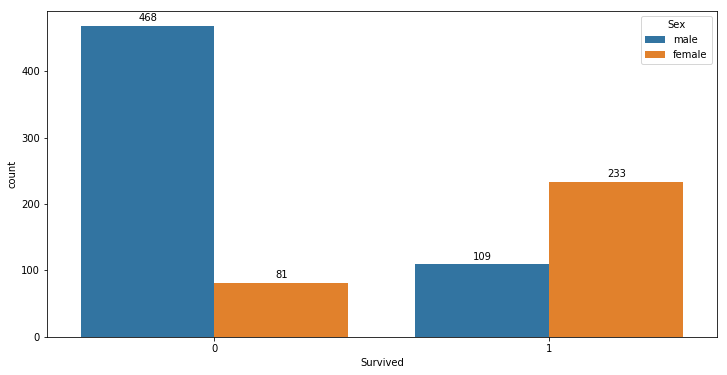

In [31]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Survived', data = train, hue = 'Sex')
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

However, we need to consider the number of female passengers vs male passengers, and normalize the results relative to the total number of passengers for each gender for fair comparison. 

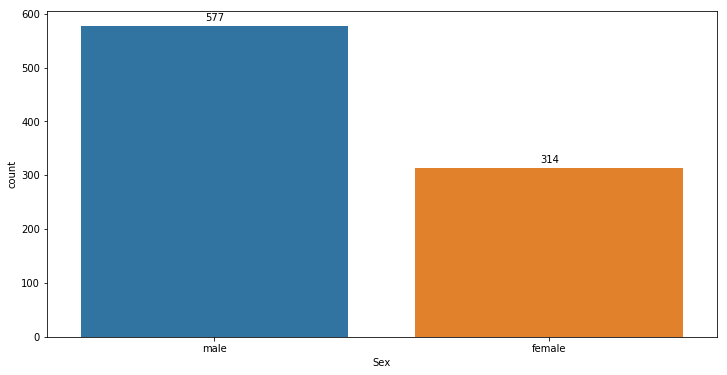

In [32]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Sex', data = train)
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

So, only $(314/891)\simeq 35\%$ of the passengers were females. Now we can normalize the numbers based on the total number of each gender, which results in

* Percentage of males who were lost is $(468/577)\simeq 81\%$
* Percentage of females who were lost is $(81/314)\simeq 26\%$

We can compute these percentages by grouping the **Survived** response variable based on the **Sex** predictor column, and then take the mean value for each group. The following compute the percentage of males and females who were lost in the disaster.

In [33]:
1-train.groupby(by = 'Sex')['Survived'].mean()

Sex
female    0.257962
male      0.811092
Name: Survived, dtype: float64

So, we can conclude that, the percentage of males who were lost relative to the total number of males was about $3.1$ times higher than the percentage of females who were lost relative to the total number of females.

## 3.1.2. Pclass:

Now, let's examine the **Pclass** effect on the survival rate. First, let's see how many passengers were there in each class:

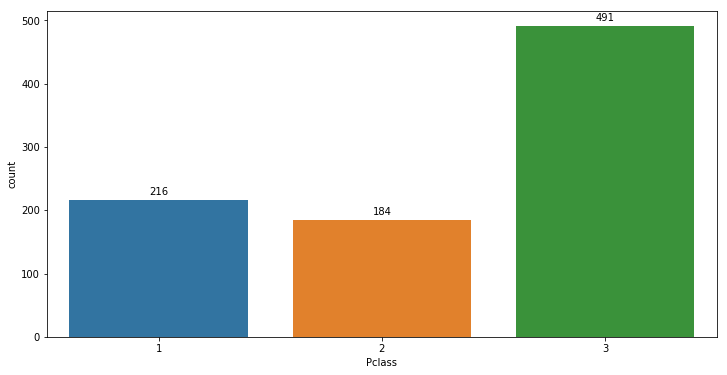

In [34]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Pclass', data = train)
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

We see that most passengers were in class 3. Now let's see how many passengers from each class were lost in the disaster:

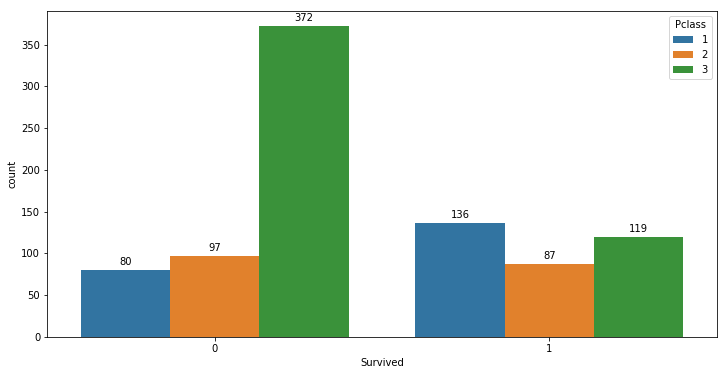

In [35]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Survived', data = train, hue = 'Pclass')
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

As percentages, these numbers are translated into

In [36]:
1 - train.groupby(by = 'Pclass')['Survived'].mean()

Pclass
1    0.370370
2    0.527174
3    0.757637
Name: Survived, dtype: float64

We can see from the above plots and percentages that passengers who traveled on class 3 were more likely to die with a probability of 0.757, followed by the second class with probability 0.527. People who traveled in class 1 were the least probable people to die with probability 0.37.

# 3.1.3 Embarked

Let us see the Embarked feature.

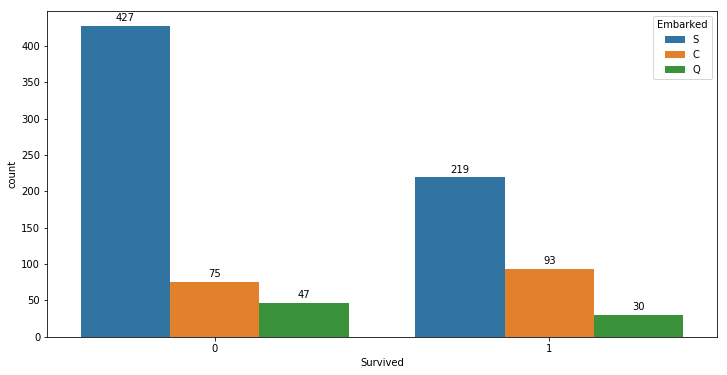

In [37]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Survived', data = train, hue = 'Embarked')
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

What is the number of passenger from each value of Emarked?

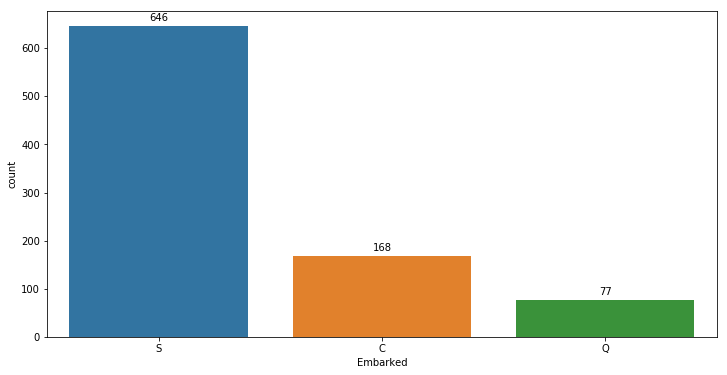

In [38]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Embarked', data = train)
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

S has the largest number of passengers. The percentages of passengers lost from each Emarked class are

In [39]:
1 - train.groupby(by = 'Embarked')['Survived'].mean()

Embarked
C    0.446429
Q    0.610390
S    0.660991
Name: Survived, dtype: float64

How these numbers are distributed across the classes?

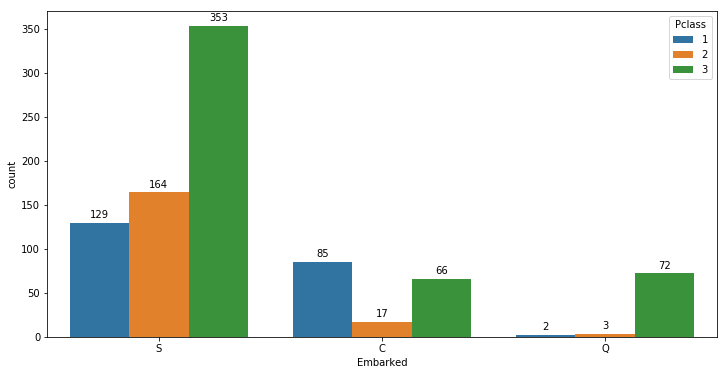

In [40]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Embarked', data = train, hue = 'Pclass')
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

We see that most passengers were embarked from port S, the majority of which were from class 3, which explains the high percentage of lost passengers from this point. The plot above also explains why the percentage of people lost from Embarked valus Q is greater than the percentage of people lost from Embarked value C, although the number of passengers from Embarked value C is greater. The reason is that almost all passengers (~93%) from Embarked value Q were of class 3. 

What is the distribution of people who were embarked from different ports based on the gender?

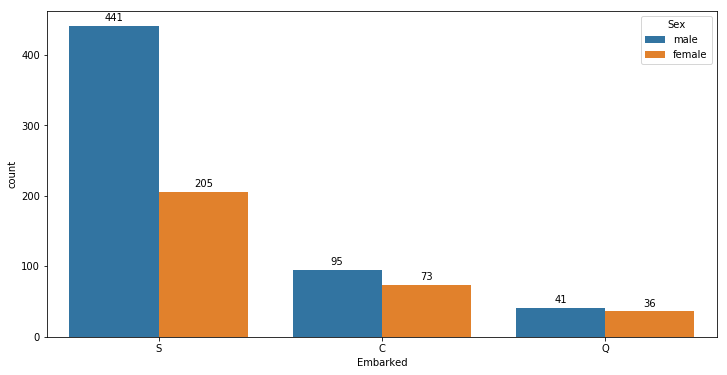

In [41]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Embarked', data = train, hue = 'Sex')
for p in g.patches:
        g.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

Now, let's us check the number of males and females of each class at each Embarked value as follows:

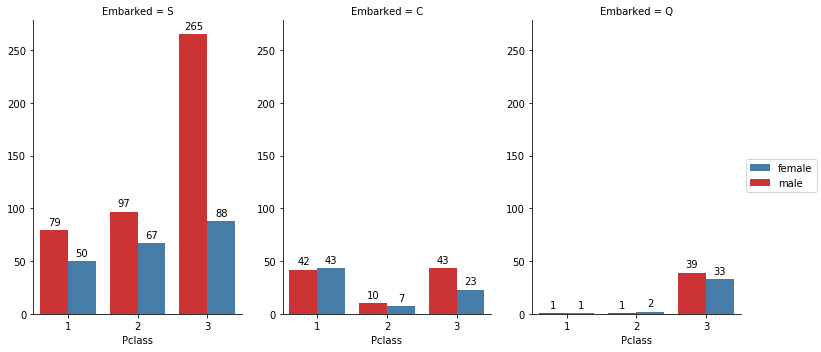

In [42]:
plt.figure(figsize = (12, 6))
g = sns.FacetGrid(train, col = 'Embarked', size = 5, aspect = 0.7)
g = (g.map(sns.countplot, 'Pclass', hue = 'Sex', data = train, palette="Set1")).add_legend()
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')
    
#sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')

Of those numbers, how many did survive?

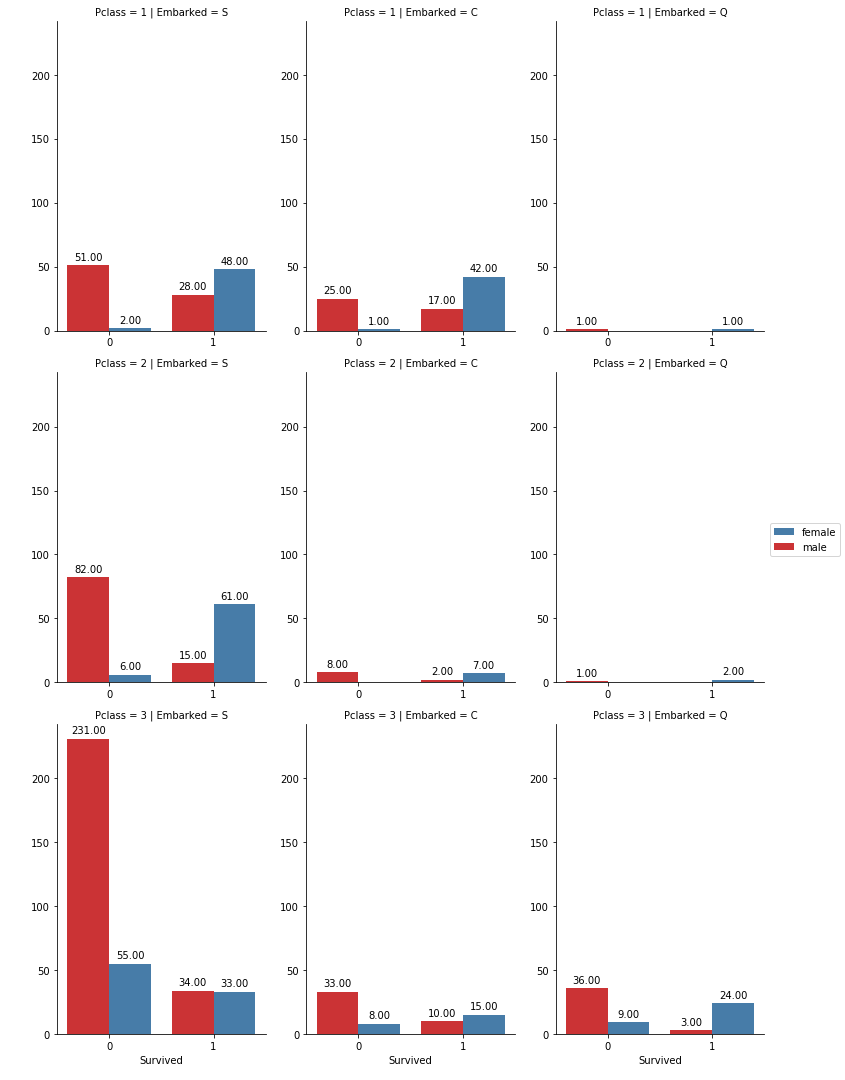

In [43]:
plt.figure(figsize = (12, 6))
g = sns.FacetGrid(train, row = 'Pclass', col = 'Embarked', size = 5, aspect = 0.7)
g = (g.map(sns.countplot, 'Survived', hue = 'Sex', data = train, palette="Set1")).add_legend()
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

Let us check the percentage of people who were lost from each Embarked value, class, and gender.

In [44]:
#ECS stands for Embarked, Class, and Sex
ECS = pd.DataFrame(train.groupby(by = ['Embarked','Pclass'])['Sex'].value_counts())
ECS_per = pd.DataFrame(round(1 - train.groupby(by = ['Embarked', 'Pclass', 'Sex'])['Survived'].mean(),3))
ECS_lost = pd.DataFrame(train.groupby(by = ['Embarked','Pclass'])['Sex'].value_counts() - train.groupby(by = ['Embarked', 'Pclass', 'Sex'])['Survived'].sum())
ECS = pd.concat([ECS, ECS_lost, ECS_per], axis = 1)
ECS.columns = ['Total number of passengers', 'Number of passengers lost', 'Percentage of passengers lost']
ECS = ECS.style.set_properties(**{'text-align': 'right'})
ECS
#ECS['Lost Percentage'] = ECS_per

From the above table we see that, for each Embarked value, the general trend is that females had a higher chance of surviving than males. Within the female group, females of different classes within each Embarked value had different chances; females of the first class had the highest chance in all Embarked values, followed by females of the second class, followed by females of the third class. The differences between males within each Embarked value is less pronounced. However, we saw earlier that males have lower chance of surviving, and the ratio of different classes is smaller than the females. This may indicate, that the Embarked value has little effect on the outcome. Let'us examine the correlation between Embarked and the Survived variables.

# 3.2 Numerical Features:
Now let us examine the numeric features.

## 3.2.1 Age
We start with the **Age** feature. Let us examine attributes of this feature.

In [45]:
train['Age'].describe()

count    891.000000
mean      29.382907
std       13.260272
min        0.420000
25%       22.000000
50%       27.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

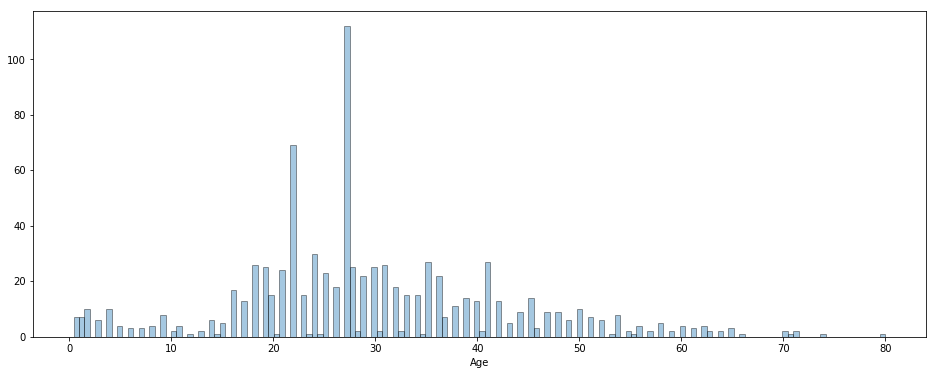

In [46]:
plt.figure(figsize = (16, 6))
sns.distplot(train['Age'], kde = False, hist_kws = {'edgecolor': 'k'}, bins = 150)

We see that **Age** is distributed from age of 5 months up to 80, with a mean of 29.3 years old.  From the 3rd quartile measure we see that 75% of the passengers were of age 36 years old and younger. Let us check the distribution based on the gender, class, and emarkation. 

In [47]:
train.groupby(by = 'Sex')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,314.0,27.334395,13.083995,0.75,21.0,24.0,35.0,63.0
male,577.0,30.497695,13.233708,0.42,23.0,27.0,37.0,80.0


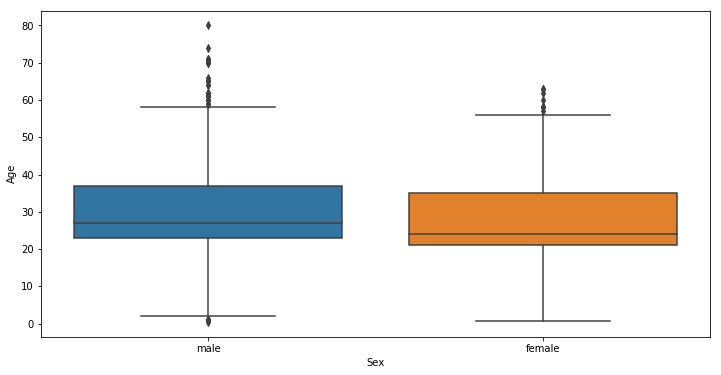

In [48]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Sex', y = 'Age', data = train)

We can see that both males and females have almost the same Inter Quartile Range (IQR). However, the male group ages is has more extreme values (that are > $1.5\times IQR)$. 

In [49]:
train.groupby(by = ['Pclass'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,38.367685,13.773749,0.92,29.00,38.0,47.25,80.0
2,184.0,29.922989,13.576274,0.67,23.00,30.0,36.00,70.0
3,491.0,25.227943,10.691145,0.42,20.25,26.0,29.00,74.0


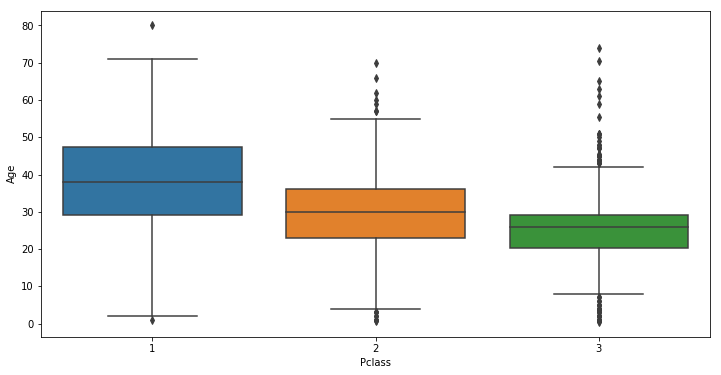

In [50]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Pclass', y = 'Age', data = train)

Based on the class, we see that Age has a wider range in class 1 and 2 compared to class 3. This means that most passengers in class 3 were young. Actually, 75% of the passengers in class 3 were of age 29 and younger. This fact, combined with the fact that most of these young people were males, probably affected the survival rate of the passengers of class 3. Let us examine the distribution of age based on gender and class.

In [51]:
train.groupby(by = ['Sex','Pclass'])['Age'].describe()

count       mean        std   min    25%   50%    75%   max
Sex    Pclass                                                             
female 1        94.0  34.648936  12.937158  2.00  24.00  35.0  42.75  63.0
       2        76.0  28.730263  12.699984  2.00  22.75  28.5  36.00  57.0
       3       144.0  21.822917  10.699032  0.75  18.00  22.0  26.00  63.0
male   1       122.0  41.232951  13.763659  0.92  33.25  41.0  49.00  80.0
       2       108.0  30.762315  14.158240  0.67  23.00  31.0  36.00  70.0
       3       347.0  26.640980  10.379472  0.42  21.00  27.0  30.00  74.0

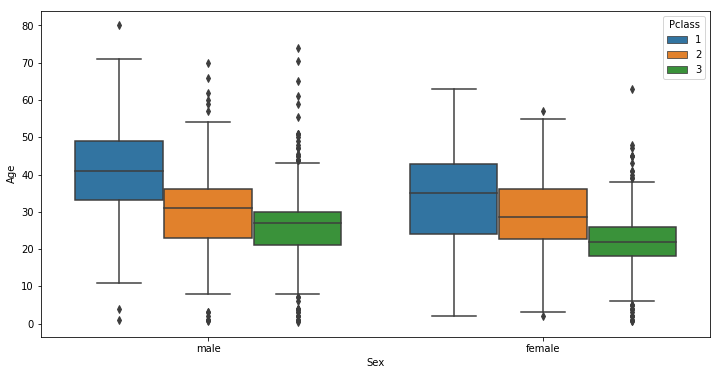

In [52]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Sex', y = 'Age', data = train, hue = 'Pclass')

We see that males and females of each class has closer distribution, with males having more outlier values. 

## 3.2.2 Fare
Now let us examine the **Fare** feature. 

In [53]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

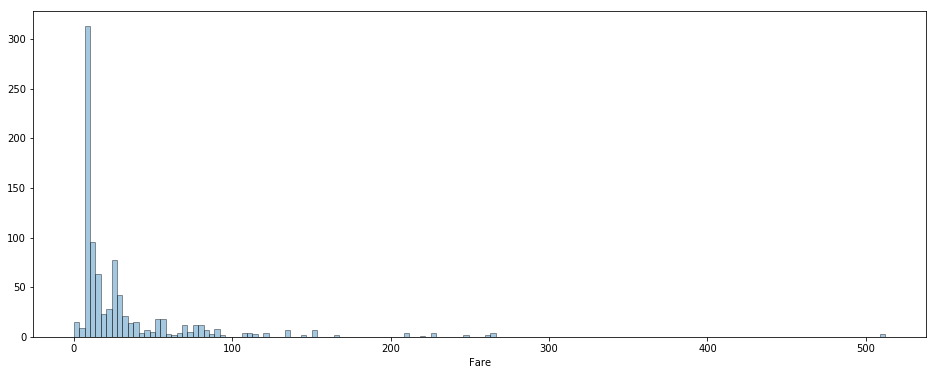

In [54]:
plt.figure(figsize = (16, 6))
sns.distplot(train['Fare'], kde = False, hist_kws = {'edgecolor': 'k'}, bins = 150)

We see that the fare price is ranged between 0 and 512.329. We also see that 75% of the fare prices is below 31, but the mean value is 32.2 (compared to the median of 14.45). This again is due to outliers in the prices. Let us examine the bocplot of the fare feature.

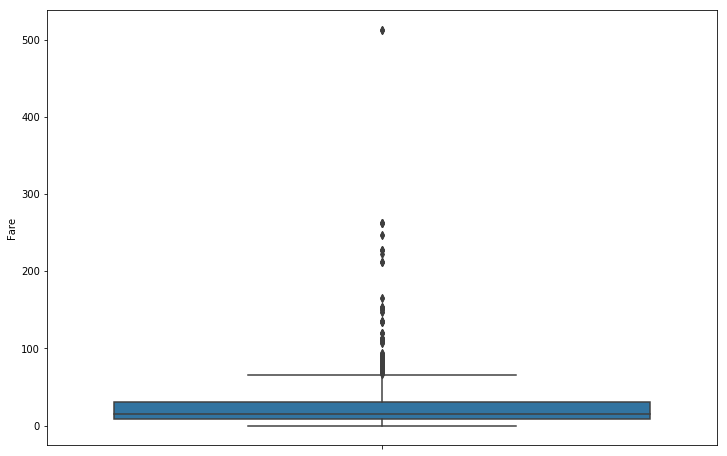

In [55]:
plt.figure(figsize = (12, 8))
sns.boxplot(y = 'Fare', data = train)

It is although the range of fare prices reaches 512, most of the prices is below 65.5 (31+1.5 * IQR). 

What is the distribution of fare based on gender?

In [56]:
train.groupby(by = 'Sex')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,314.0,44.479818,57.997698,6.75,12.071875,23.0,55.00,512.3292
male,577.0,25.523893,43.138263,0.00,7.895800,10.5,26.55,512.3292


Unlike age, the fare feature has more discrepency between males and females, where the male tickects are cheaper.

What is the distribution of fare based on class?

In [57]:
train.groupby(by = 'Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


We see that the fare is less dispersed in classes 2 and 3 than in class 1. 

What is the distribution of fare based on Sex and Class?

In [58]:
train.groupby(by = ['Sex', 'Pclass'])['Fare'].describe()

count        mean        std      min       25%       50%  \
Sex    Pclass                                                              
female 1        94.0  106.125798  74.259988  25.9292  57.24480  82.66455   
       2        76.0   21.970121  10.891796  10.5000  13.00000  22.00000   
       3       144.0   16.118810  11.690314   6.7500   7.85420  12.47500   
male   1       122.0   67.226127  77.548021   0.0000  27.72810  41.26250   
       2       108.0   19.741782  14.922235   0.0000  12.33125  13.00000   
       3       347.0   12.661633  11.681696   0.0000   7.75000   7.92500   

                      75%       max  
Sex    Pclass                        
female 1       134.500000  512.3292  
       2        26.062500   65.0000  
       3        20.221875   69.5500  
male   1        78.459375  512.3292  
       2        26.000000   73.5000  
       3        10.008300   69.5500

## 3.2.3 SibSP
Now let us examine the SibSp (Sibling Spouse) feature.

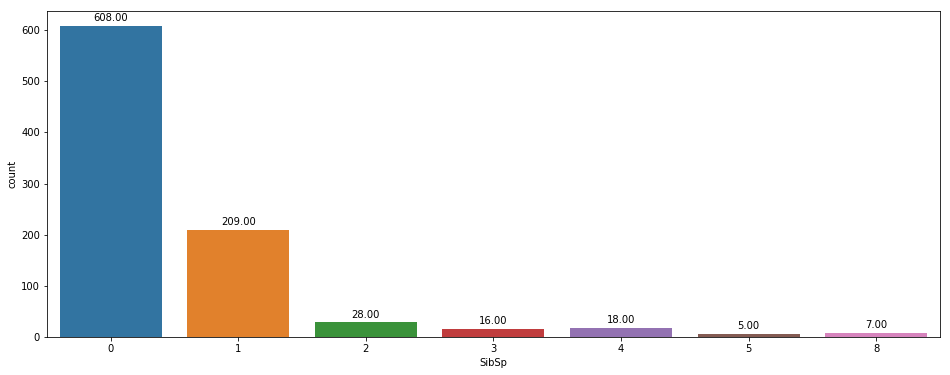

In [59]:
plt.figure(figsize = (16, 6))
g = sns.countplot(x = 'SibSp', data = train)
for p in g.patches:
        g.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

We see that most passengers were either alone, or with one sibling/spouse. 

## 3.2.4 ParCh
Now, let us examine the ParCh (parent/child) feature.

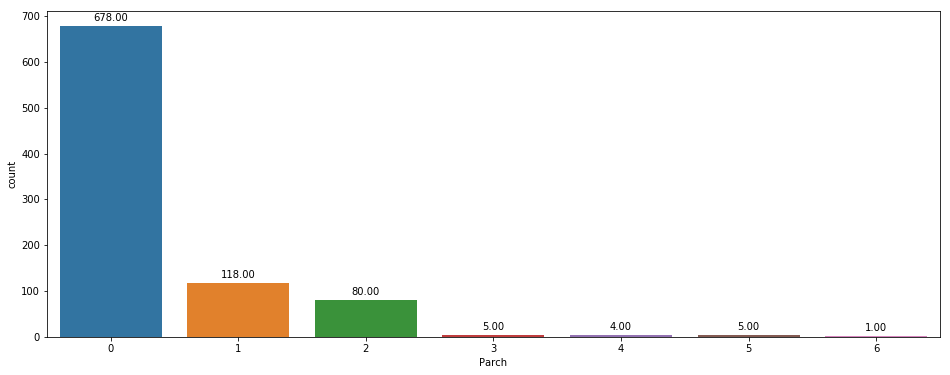

In [60]:
plt.figure(figsize = (16, 6))
g = sns.countplot(x = 'Parch', data = train)
for p in g.patches:
        g.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

We see that most passengers were either alone, or with 1 or 2 parent/child.

Let us examine the correlation of all predictors with the response variable. To this end, we need first to convert the categorical features into numeric features as follows:

In [61]:
train_get_dummy = pd.get_dummies(columns=['Sex', 'Pclass', 'Embarked'], drop_first = True, data = train)
train_get_dummy.head()

,Age,SibSp,Parch,Fare,Survived,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
index,,,,,,,,,,
0,22.0,1,0,7.2500,0,1,0,1,0,1
1,38.0,1,0,71.2833,1,0,0,0,0,0
2,26.0,0,0,7.9250,1,0,0,1,0,1
3,35.0,1,0,53.1000,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,1,0,1


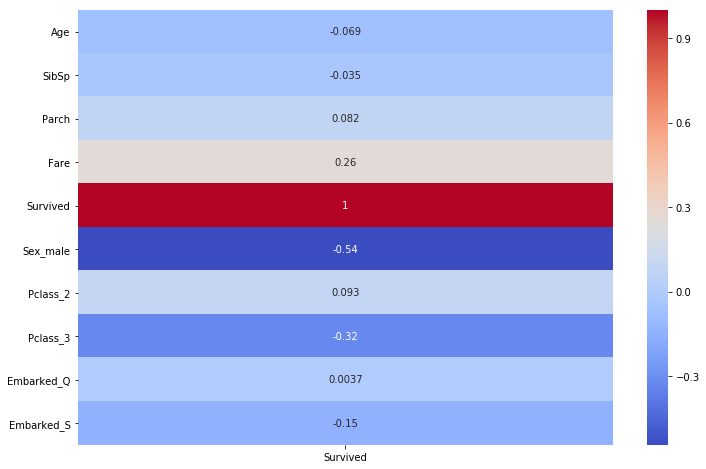

In [62]:
plt.figure(figsize = (12, 8))
sns.heatmap(pd.DataFrame(train_get_dummy.corr().unstack()['Survived'], 
                         columns = ['Survived']), annot = True, cmap = 'coolwarm')

The most correlated features with the response variable are: Sex_male (negative), Fare (positive), and Pclass_3 (negative).   

# 4. Training and tentative evaluation of the model:
At this stage, we reached to the point we are ready to use machine learning algorithms on our data. Since we have the response variable only in the training dataset, we will split it into two parts: training part to train the model, and testing part to test the performance of our model. Since this is a binary classification problem, we will be using logistic regression. 

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import statsmodels.api as sm
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

C:\Anacoda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [64]:
def forward_stepwise_selection(df):
    '''
    This function takes as an input a dataframe with Survived as one of its columns performs forward
    stepwise selection on the features. For a given number of features, R-squared is used to determine
    the best predictor to add. After having the P models (P is the number of predictors), we select the best
    model size using 5-fold cross validation mean score.
    '''
    p = len(df.columns)#the total number of predictors
    X = df.drop('Survived', axis = 1)
    columns = list(X.columns)
    y = df['Survived']
    best_cols_global = []
    for col1 in columns:
        max_score = -1
        for col2 in columns:
            model = LogisticRegression()
            if col2 not in best_cols_global:
                cols = best_cols_global[:]
                #print(cols)
                cols.append(col2)
                #print(cols)
                model.fit(X[cols], y)
                score = model.score(X[cols], y)
                if score > max_score:
                    max_score = score
                    best_col = col2
                    #print(best_col)
        if best_col not in best_cols_global:        
            best_cols_global.append(best_col)
        print(best_cols_global, max_score)
        model = LogisticRegression()
        mean_score = cross_val_score(model, X[best_cols_global], y, cv = 5).mean()
        print('CV mean score is ', mean_score)

In [65]:
forward_stepwise_selection(train_get_dummy)

['Sex_male'] 0.786756453423
CV mean score is  0.786715024929
['Sex_male', 'SibSp'] 0.791245791246
CV mean score is  0.788974911935
['Sex_male', 'SibSp', 'Pclass_3'] 0.800224466891
CV mean score is  0.799087342413
['Sex_male', 'SibSp', 'Pclass_3', 'Age'] 0.803591470258
CV mean score is  0.801340952349
['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S'] 0.811447811448
CV mean score is  0.805829128228
['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S', 'Fare'] 0.812570145903
CV mean score is  0.801341094203
['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S', 'Fare', 'Pclass_2'] 0.812570145903
CV mean score is  0.804724505787
['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S', 'Fare', 'Pclass_2', 'Embarked_Q'] 0.812570145903
CV mean score is  0.804724505787
['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S', 'Fare', 'Pclass_2', 'Embarked_Q', 'Parch'] 0.810325476992
CV mean score is  0.799119011471


From the above summary, we see that the features ['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S'] gives the highest mean score among all model sizes. So, we will use these features only, and drop the rest. 

In [66]:
def summary_results(df):
    '''
    This function takes as input a dataframe that has Survived as one of its columns, and
    does the following:
    
    1- Split the dataframe into a training and testing dataset with a test size of 0.3.
    2- Define a list of models to be used
    3- Train each model
    4- Make predictions on the testing dataset
    
    The outputs of the function is:
    1- The acuuracy of the models using the confusion matrix
    2- the 5-fold cross-validation mean score of the models.
    '''
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis = 1),
                                                       df['Survived'],
                                                       test_size = 0.3,
                                                       random_state = 100)
    pca = PCA(n_components = 3)

    X_train = scale(X_train)
    X_test = scale(X_test) 
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)


    
    k_max = -10
    mean_score_max = -10
    for kk in range(1, 20, 2):
        KNN_model = KNeighborsClassifier(n_neighbors = kk)
        mean_score = cross_val_score(KNN_model, df.drop('Survived', axis = 1),
                                df['Survived'], cv = 10).mean()
    #print('K = ', kk, 'mean score = ', mean_score)
        if mean_score > mean_score_max:
            mean_score_max = mean_score
            k_max = kk
            
    print('The best K for K-NN using 5-fold CV is ', k_max)
    
    DC = DummyClassifier(strategy = 'most_frequent')
    LR = LogisticRegression()
    LDA = LinearDiscriminantAnalysis()
    QDA = QuadraticDiscriminantAnalysis()
    KNN = KNeighborsClassifier(n_neighbors = k_max)
    DTC = DecisionTreeClassifier()
    BC = BaggingClassifier(n_estimators = 300)
    RFC = RandomForestClassifier(n_estimators = 300)
    SVCL = SVC(C = 1, probability = True)
    MLC = MultinomialNB()
    VC = VotingClassifier(estimators=[('lr', LR), 
                                      #('LDA', LDA),
                                      ('QDA', QDA),
                                     # ('DTC', DTC),
                                      ('BC', BC),
                                      ('RFC', RFC),
                                      ('SVC', SVCL),
                                      #('MLC', MLC),
                                      #('KNN', KNN)
                                     ], 
                          voting = 'soft')
    
    classifiers = [DC, 
                   LR, 
                   LDA, 
                   QDA,
                   DTC,
                   BC,
                   RFC,
                   KNN,
                   SVCL,
                  # MLC,
                   VC]
    
    list_of_classifiers = ['Null Classifier',
                           'Logistic Regression', 
                           'Linear Discriminant Analaysis', 
                           'Quadratic Discriminant Analysis', 
                           'Decision Tree Classifier',
                           'Bagging Classifier',
                           'Random Forest Classifier',
                           'K-Nearest Neighbors', 
                           'Support Vector Classifier',
                           #'Multinomial Naive Bayes',
                           'Voting Classifier']
    max_len = max(list_of_classifiers, key = len)#this returns the string of the maximum length
    
#     scaler = StandardScaler()
#     X_train_KNN = scaler.fit_transform(X_train)
#     X_test_KNN = scaler.fit_transform(X_test)
    
    
    print('================================================================================')   
    print('{}{}{}{}'.format('Model Name:', ' '*(len(max_len)-len('Model Name:')+3), 'Accuracy', '\t5-fold CV Mean Score'))
    print('================================================================================')   

    i = 0
    for model in classifiers:
        model.fit(X_train, y_train)
        pred = model.predict(X_test) 
        Con_mat = confusion_matrix(y_test, pred)
        acc = (Con_mat[0,0]+Con_mat[1,1])/(Con_mat[0,0]+Con_mat[0,1]+Con_mat[1,0]+Con_mat[1,1])
        mean_score = cross_val_score(model, df.drop('Survived', axis = 1), df['Survived'], cv = 5).mean()
        diff = len(max_len)-len(list_of_classifiers[i])+5
        print('{}{}{:.3f}\t{:.3f}'.format(list_of_classifiers[i], ' '*diff, acc, mean_score))
        #print(list_of_classifiers[i], acc)
        i += 1
        
#     print('================================================================================')   
#     print('\n'*2)
#     print(' '*15+'Summary result of the logistic regression model')
#     print('\n'*2)
#     print('================================================================================') 
#     X_train = sm.add_constant(X_train)
#     model_stats = sm.Logit(y_train, X_train)
#     result = model_stats.fit()
#     print(result.summary2())

## 4.1 Null Classifier
The null classifier assumes that all passengers didn't survive (assumes the most frequent class for all passengers). This classifiers  serves as the worst classifier with the lowest accuracy. . 

## 4.2 Logistic regression, LDA,  QDA, DTC, BC, RFC, and K-NN:

We will consider the following classifiers: logistic regression, linear discriminant analysis, quadratic discriminant analysis, decision tree classifier, bagging classifier, random forest classifier, and K-NN. The following is a summary for the accuracy of all the models 

In [67]:
summary_results(train_get_dummy[['Survived','Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S']])

The best K for K-NN using 5-fold CV is  11
Model Name:                       Accuracy	5-fold CV Mean Score
Null Classifier                     0.593	0.616
Logistic Regression                 0.772	0.806
Linear Discriminant Analaysis       0.772	0.796
Quadratic Discriminant Analysis     0.795	0.802
Decision Tree Classifier            0.757	0.795
Bagging Classifier                  0.761	0.799
Random Forest Classifier            0.772	0.797
K-Nearest Neighbors                 0.791	0.772
Support Vector Classifier           0.784	0.815
Voting Classifier                   0.791	0.820


Since our goal is to predict if a passenger survived or not based on his/her predictor variables, and there is no different costs associated with a passenger predicted as survived or not, the accuracy metric is a good indicator for the performance of the model, which is found by summing the diagonal elements in the confusion matrix divided by the total number of observations. A more accurate performance measure is the cross validation score, since all the training data is used for both training and evaluating the model.  

We note from the above summary that bagging classifier has the highest mean score. The voting classifier that uses soft decisions from all the individual classifiers listed above except LDA, DTC and KNN (because they scored < 80% accuracy) performs better than  any individual classifier.

Next, we will prepare the test data, and use voting classifier to predict the response variable. 

# 5. Test Data Predictions:

In [68]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
index,,,,,,,
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [69]:
test_get_dummies = pd.get_dummies(test, columns = ['Sex', 'Pclass', 'Embarked'], drop_first = True)
test_get_dummies = test_get_dummies[['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S']]
test_get_dummies.head()

,Sex_male,SibSp,Pclass_3,Age,Embarked_S
index,,,,,
0,1,0,1,34.5,0
1,0,1,1,47.0,1
2,1,0,0,62.0,0
3,1,0,1,27.0,1
4,0,1,1,22.0,1


Let us make the predictions on the processed test dataset. To this end, we need to train the model using **ALL**  training data.

In [70]:
LR = LogisticRegression()
LDA = LinearDiscriminantAnalysis()
QDA = QuadraticDiscriminantAnalysis()
KNN = KNeighborsClassifier(n_neighbors = 11)
DTC = DecisionTreeClassifier()
BC = BaggingClassifier(n_estimators = 300)
RFC = RandomForestClassifier(n_estimators = 300)
SVCL = SVC(probability = True)
best_model = VotingClassifier(estimators=[('lr', LR), 
                                      #('LDA', LDA),
                                      ('QDA', QDA),
                                     # ('DTC', DTC),
                                      ('BC', BC),
                                      ('RFC', RFC),
                                      ('SVC', SVCL),
                                      #('KNN', KNN)
                                     ], 
                          voting = 'soft')

In [71]:
best_model.fit(train_get_dummy[['Sex_male', 'SibSp', 'Pclass_3', 'Age', 'Embarked_S']], 
               train_get_dummy['Survived'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('QDA', Quadra...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

Let us prepare the final file that contains the predictions in the required format.

In [72]:
PssID_df = pd.DataFrame(PssId, columns = ['PassengerId'])
PssID_df['Survived'] = best_model.predict(test_get_dummies)
PssID_df.to_csv('final_result.csv', index = False)
PssID_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


The scored result using the above method is 0.77511, which is subject to improvement using more complex algorithms. 